# Imports

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.constraints import MaxNorm
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.initializers import HeNormal, GlorotUniform

import warnings        
warnings.filterwarnings("ignore") # ignores warnings

# Constants

In [2]:
n_samples = 10000
test_samples = 3000
a1 = np.array([3, 3], dtype=np.float32)
a2 = np.array([-3, -3], dtype=np.float32)
epoch_counts = [5, 10, 20, 50, 75, 100]
neuron_counts = range(1, 21)

# Generate train and test data

In [9]:
# Define the data generation function
def generate_data(n):
    X = np.random.randn(n, 2).astype(np.float32)
    Z = np.random.standard_normal(n).astype(np.float32)
    Y = (tf.nn.sigmoid(a1 @ X.T) + ((a2 @ X.T)**2) + (0.30 * Z)).numpy()
    return X, Y

# Data preparation
X_train, Y_train = generate_data(n_samples)
X_test, Y_test = generate_data(test_samples)

np.savez_compressed('data.npz', X_train=X_train, Y_train=Y_train, X_test=X_test, Y_test=Y_test)

# Load the generated data

In [3]:
data = np.load('data.npz')
X_train = data['X_train']
Y_train = data['Y_train']
X_test = data['X_test']
Y_test = data['Y_test']

# Part 1:
### Plot the training and test error curves as a function of the number of training epochs (Use the root mean squared error metric RMSE to evaluate the training and test errors), try several epochs numbers i.e. 5, 10, 20, 50, ,75 ,100. Discuss the overfitting behavior in each case

6it [00:35,  5.99s/it]


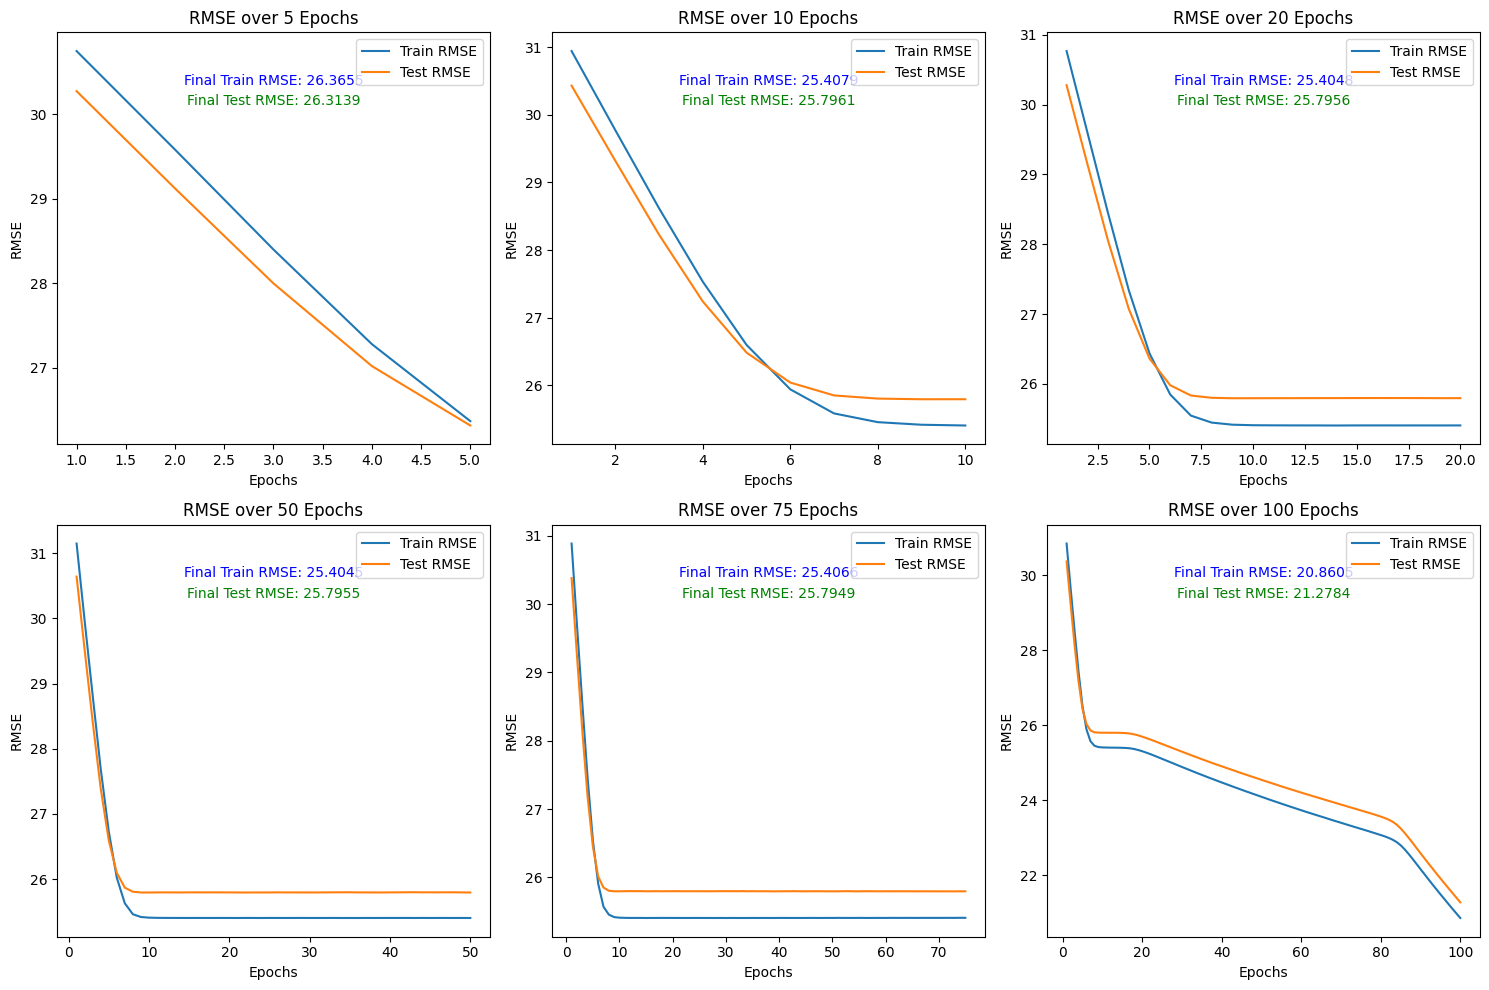

In [12]:
# Create the model defention
def create_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(10, activation='sigmoid', input_shape=(2,)),
        tf.keras.layers.Dense(1, activation='linear')
    ])
    model.compile(loss='mse')
    return model

# Setup grid for drawing the results
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10)) 
axes = axes.flatten()

# Try for each epoch count
for i, epochs in tqdm(enumerate(epoch_counts)):
    model = create_model()
    history = model.fit(X_train, Y_train, epochs=epochs, validation_data=(X_test, Y_test), verbose=0)

    # RMSE
    train_rmse = np.sqrt(history.history['loss'])
    test_rmse = np.sqrt(history.history['val_loss'])

    # Plotting
    ax = axes[i]
    ax.plot(range(1, epochs + 1), train_rmse, label='Train RMSE')
    ax.plot(range(1, epochs + 1), test_rmse, label='Test RMSE')
    ax.set_title(f'RMSE over {epochs} Epochs')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('RMSE')
    ax.legend()

    # Annotate final RMSE values
    final_train_rmse = train_rmse[-1]
    final_test_rmse = test_rmse[-1]
    ax.text(0.5, 0.9, f'Final Train RMSE: {final_train_rmse:.4f}', transform=ax.transAxes, ha='center', va='top', fontsize=10, color='blue')
    ax.text(0.5, 0.85, f'Final Test RMSE: {final_test_rmse:.4f}', transform=ax.transAxes, ha='center', va='top', fontsize=10, color='green')

# Adjust layout and show plot
plt.tight_layout()
plt.show()

# Part 2
### Vary the number of hidden layer in the network, from 1 up to 20, and determine the minimum number needed to perform well for this task.

100%|█████████████████████████████████████████████| 20/20 [03:02<00:00,  9.12s/it]


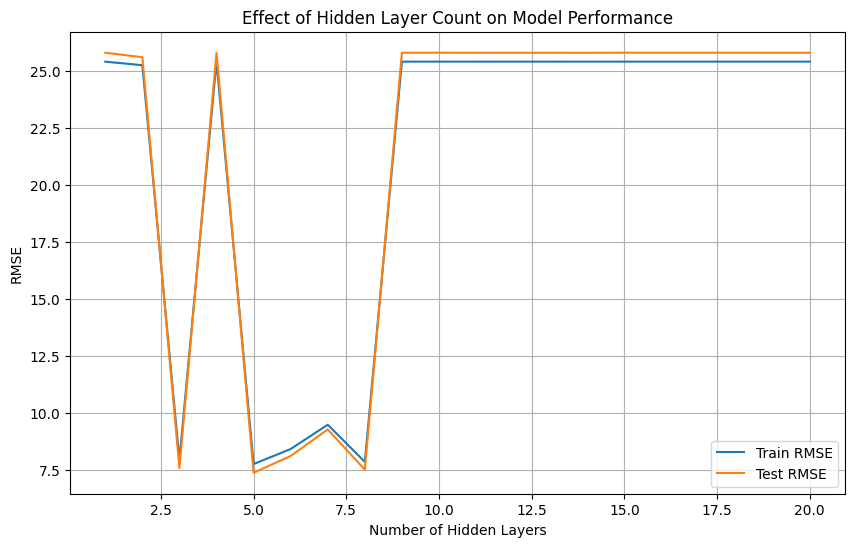

In [13]:
def create_model(num_hidden_layers, neurons_per_layer=10):
    model = tf.keras.Sequential()
    for _ in range(num_hidden_layers):
        model.add(tf.keras.layers.Dense(neurons_per_layer, activation='sigmoid', input_shape=(2,)))
    model.add(tf.keras.layers.Dense(1, activation='linear'))
    return model

layer_counts = range(1, 21)
train_rmse_results = []
test_rmse_results = []

for layers in tqdm(layer_counts):
    model = create_model(num_hidden_layers=layers)
    model.compile(loss='mse')
    
    history = model.fit(X_train, Y_train, epochs=50, validation_data=(X_test, Y_test), verbose=0)
    
    # Calculate RMSE for training and test
    train_rmse = np.sqrt(history.history['loss'][-1])
    test_rmse = np.sqrt(history.history['val_loss'][-1])
    
    train_rmse_results.append(train_rmse)
    test_rmse_results.append(test_rmse)

# Plotting results
plt.figure(figsize=(10, 6))
plt.plot(layer_counts, train_rmse_results, label='Train RMSE')
plt.plot(layer_counts, test_rmse_results, label='Test RMSE')
plt.xlabel('Number of Hidden Layers')
plt.ylabel('RMSE')
plt.title('Effect of Hidden Layer Count on Model Performance')
plt.legend()
plt.grid(True)
plt.show()

## The best number of hidden layers is 5 which gave the lowest rmse while maintaining the lowest complixity.
## After that increasing the model complexity caused some kind of underfitting after 7 hidden layers

# Part 3
### Try to optimize the feed-forward neural network built in 2 to reach the best possible accuracy by tune
### a. Overfitting avoiding i.e. early stopping, L1 and L2 regularization (try several values of λ), max-norm, and dropout
### b. Vanishing gradient overcoming, i.e. parameter initialization, none saturation activation function, batch normalization, and gradient clipping.
### c. The optimizer and its hyperparameters
### d. The number of neurons of the hidden layers.
### e. The mini-batches of training
### f. Activation function for the hidden layers (i.e. tanh, ReLU, linear, etc.)

### a. Overfitting avoiding i.e. early stopping, L1 and L2 regularization (try several values of λ), max-norm, and dropout

In [13]:
# Data split
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)

def create_model(input_shape, num_neurons, num_layers, activation, l1_reg=None, l2_reg=None, dropout_rate=None, max_norm_value=None):
    model = Sequential()
    for i in range(num_layers):
        if l1_reg is not None or l2_reg is not None:
            regularizer = l1_l2(l1=l1_reg if l1_reg is not None else 0,
                                l2=l2_reg if l2_reg is not None else 0)
        else:
            regularizer = None

        constraint = MaxNorm(max_value=max_norm_value) if max_norm_value is not None else None

        if i == 0:
            model.add(Dense(num_neurons, activation=activation, input_shape=input_shape,
                            kernel_regularizer=regularizer,
                            kernel_constraint=constraint))
        else:
            model.add(Dense(num_neurons, activation=activation,
                            kernel_regularizer=regularizer,
                            kernel_constraint=constraint))
        
        if dropout_rate is not None:
            model.add(Dropout(dropout_rate))

    model.add(Dense(1, activation='linear'))
    return model

def train_and_evaluate(model, X_train, Y_train, X_val, Y_val, epochs=100):
    model.compile(loss='mse')
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    model.fit(X_train, Y_train, epochs=epochs, validation_data=(X_val, Y_val), verbose=0, callbacks=[early_stopping])
    train_rmse = np.sqrt(model.evaluate(X_train, Y_train, verbose=0))
    val_rmse = np.sqrt(model.evaluate(X_val, Y_val, verbose=0))
    return train_rmse, val_rmse

regularization_params = [(0.01, 0.01), (0.001, 0.01), (0.01, 0.001)]
dropout_rates = [0.2, 0.3, None]
max_norm_params = [3, None]  # Note 100000 is treated as 'no constraint'

# Loop over configurations
for l1_reg, l2_reg in regularization_params:
    for dropout_rate in dropout_rates:
        for max_norm in max_norm_params:
            model = create_model((2,), 10, 5, 'sigmoid', l1_reg, l2_reg, dropout_rate, max_norm)
            train_rmse, val_rmse = train_and_evaluate(model, X_train, Y_train, X_val, Y_val)
            print(f"Training RMSE: {train_rmse:.4f}, Validation RMSE: {val_rmse:.4f} with L1={l1_reg}, L2={l2_reg}, Dropout={dropout_rate}, Max-norm={max_norm}")

Training RMSE: 25.7047, Validation RMSE: 26.0154 with L1=0.01, L2=0.01, Dropout=0.2, Max-norm=3
Training RMSE: 25.7051, Validation RMSE: 26.0161 with L1=0.01, L2=0.01, Dropout=0.2, Max-norm=None
Training RMSE: 25.7114, Validation RMSE: 26.0245 with L1=0.01, L2=0.01, Dropout=0.3, Max-norm=3
Training RMSE: 25.7145, Validation RMSE: 26.0297 with L1=0.01, L2=0.01, Dropout=0.3, Max-norm=None
Training RMSE: 25.7008, Validation RMSE: 26.0046 with L1=0.01, L2=0.01, Dropout=None, Max-norm=3
Training RMSE: 25.6992, Validation RMSE: 26.0026 with L1=0.01, L2=0.01, Dropout=None, Max-norm=None
Training RMSE: 25.7017, Validation RMSE: 26.0120 with L1=0.001, L2=0.01, Dropout=0.2, Max-norm=3
Training RMSE: 25.7002, Validation RMSE: 26.0086 with L1=0.001, L2=0.01, Dropout=0.2, Max-norm=None
Training RMSE: 25.7053, Validation RMSE: 26.0195 with L1=0.001, L2=0.01, Dropout=0.3, Max-norm=3
Training RMSE: 25.7049, Validation RMSE: 26.0183 with L1=0.001, L2=0.01, Dropout=0.3, Max-norm=None
Training RMSE: 25.6

### All combinations showed similar results with an advantage for  Training RMSE: 25.6964, Validation RMSE: 25.9991 with L1=0.001, L2=0.01, Dropout=None, Max-norm=3


### b. Vanishing gradient overcoming, i.e. parameter initialization, none saturation activation function, batch normalization, and gradient clipping.
### c. The optimizer and its hyperparameters
### f. Activation function for the hidden layers (i.e. tanh, ReLU, linear, etc.)

In [6]:
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)

def create_model(num_neurons=10, num_layers=5, initializer='he_normal', activation='relu',
                 batch_normalization=False, gradient_clipping=None, optimizer_type='adam', learning_rate=0.001, momentum=None):
    model = Sequential()
    for i in range(num_layers):
        model.add(Dense(num_neurons, activation=activation, input_shape=(2,),
                        kernel_initializer=initializer))
        if batch_normalization:
            model.add(BatchNormalization())
        if i < num_layers - 1: 
            model.add(Dropout(0.3))
    model.add(Dense(1, activation='linear'))

    # Selecting the optimizer based on the input parameter
    if optimizer_type == 'adam':
        optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate, clipvalue=gradient_clipping if gradient_clipping else None)
    elif optimizer_type == 'sgd':
        optimizer = tf.keras.optimizers.legacy.SGD(learning_rate=learning_rate, momentum=momentum if momentum else 0.0, clipvalue=gradient_clipping if gradient_clipping else None)
    elif optimizer_type == 'rmsprop':
        optimizer = tf.keras.optimizers.legacy.RMSprop(learning_rate=learning_rate, momentum=momentum if momentum else 0.0, clipvalue=gradient_clipping if gradient_clipping else None)

    model.compile(optimizer=optimizer, loss='mse')
    return model

# Experiment settings
initializers = [HeNormal(seed=42), GlorotUniform(seed=42)]
activations = ['relu', 'tanh', 'linear']
batch_normalizations = [True, False]
gradient_clippings = [None, 0.5, 1.0]
optimizers = [
    {'type': 'adam', 'learning_rate': 0.001},
    {'type': 'sgd', 'learning_rate': 0.01, 'momentum': 0.9},
    {'type': 'rmsprop', 'learning_rate': 0.001}
]

# Running the experiments
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
for init in initializers:
    for act in activations:
        for batch_norm in batch_normalizations:
            for grad_clip in gradient_clippings:
                for optimizer_settings in optimizers:
                    print(f"\nTraining model with init={type(init).__name__}, activation={act}, batch_norm={batch_norm}, "
                          f"grad_clip={grad_clip}, optimizer={optimizer_settings['type']}, lr={optimizer_settings['learning_rate']}")
                    model = create_model(initializer=init, activation=act, 
                                         batch_normalization=batch_norm, gradient_clipping=grad_clip,
                                         optimizer_type=optimizer_settings['type'], learning_rate=optimizer_settings['learning_rate'],
                                         momentum=optimizer_settings.get('momentum'))
                    model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=50,
                              callbacks=[early_stopping], verbose=0)
                    train_rmse = np.sqrt(model.evaluate(X_train, Y_train, verbose=0))
                    val_rmse = np.sqrt(model.evaluate(X_val, Y_val, verbose=0))
                    print(f"Results - Training RMSE: {train_rmse:.4f}, Validation RMSE: {val_rmse:.4f}")


Training model with init=HeNormal, activation=relu, batch_norm=True, grad_clip=None, optimizer=adam, lr=0.001
Results - Training RMSE: 5.0556, Validation RMSE: 4.3818

Training model with init=HeNormal, activation=relu, batch_norm=True, grad_clip=None, optimizer=sgd, lr=0.01
Results - Training RMSE: nan, Validation RMSE: nan

Training model with init=HeNormal, activation=relu, batch_norm=True, grad_clip=None, optimizer=rmsprop, lr=0.001
Results - Training RMSE: 7.5474, Validation RMSE: 7.1942

Training model with init=HeNormal, activation=relu, batch_norm=True, grad_clip=0.5, optimizer=adam, lr=0.001
Results - Training RMSE: 10.1891, Validation RMSE: 9.6118

Training model with init=HeNormal, activation=relu, batch_norm=True, grad_clip=0.5, optimizer=sgd, lr=0.01
Results - Training RMSE: 9.2534, Validation RMSE: 8.3419

Training model with init=HeNormal, activation=relu, batch_norm=True, grad_clip=0.5, optimizer=rmsprop, lr=0.001
Results - Training RMSE: 9.7404, Validation RMSE: 8.358

## Adding a good optimizer, initalizer, batch normalization and activation function showed magnificent improvment in the model accuracy!!
### Training model with init=HeNormal, activation=relu, batch_norm=True, grad_clip=None, optimizer=adam, lr=0.001 Results - Training RMSE: 5.0556, Validation RMSE: 4.3818

### d. The number of neurons of the hidden layers.
### e. The mini-batches of training

In [4]:
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)

def create_model(num_neurons, num_layers=5, batch_size=32):
    model = Sequential()
    model.add(Dense(num_neurons, activation='relu', input_shape=(2,), kernel_initializer=HeNormal(seed=42),
                    kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.001, l2=0.01)))
    for _ in range(1, num_layers):
        model.add(Dense(num_neurons, activation='relu', kernel_initializer=HeNormal(seed=42),
                        kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.001, l2=0.01)))
        model.add(BatchNormalization())
        model.add(Dropout(0.3))
    model.add(Dense(1, activation='linear'))
    model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.001), loss='mse')
    return model

# Different configurations for number of neurons and batch sizes
neuron_counts = [10, 50, 100, 200]
batch_sizes = [16, 32, 64, 128]

# Early stopping for training
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Running experiments
for neurons in neuron_counts:
    for batch_size in batch_sizes:
        print(f"\nTraining model with {neurons} neurons per layer and batch size {batch_size}")
        model = create_model(num_neurons=neurons, batch_size=batch_size)
        history = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=50,
                            batch_size=batch_size, callbacks=[early_stopping], verbose=0)
        train_rmse = np.sqrt(model.evaluate(X_train, Y_train, verbose=0))
        val_rmse = np.sqrt(model.evaluate(X_val, Y_val, verbose=0))
        print(f"Results - Training RMSE: {train_rmse:.4f}, Validation RMSE: {val_rmse:.4f}")


Training model with 10 neurons per layer and batch size 16
Results - Training RMSE: 5.4909, Validation RMSE: 6.4677

Training model with 10 neurons per layer and batch size 32
Results - Training RMSE: 4.3206, Validation RMSE: 4.7918

Training model with 10 neurons per layer and batch size 64
Results - Training RMSE: 5.7316, Validation RMSE: 7.0873

Training model with 10 neurons per layer and batch size 128
Results - Training RMSE: 4.8150, Validation RMSE: 5.7969

Training model with 50 neurons per layer and batch size 16
Results - Training RMSE: 3.3775, Validation RMSE: 3.7915

Training model with 50 neurons per layer and batch size 32
Results - Training RMSE: 3.1171, Validation RMSE: 3.3241

Training model with 50 neurons per layer and batch size 64
Results - Training RMSE: 3.2294, Validation RMSE: 3.6413

Training model with 50 neurons per layer and batch size 128
Results - Training RMSE: 3.8097, Validation RMSE: 4.3535

Training model with 100 neurons per layer and batch size 16
R

## The best results:
### Training model with 50 neurons per layer and batch size 32 [Results - Training RMSE: 3.1171, Validation RMSE: 3.3241]